# Task. 3 Discrete Models
### Ivan Dubinin, 335433, J41321
#### - Implement and compare all (four) models (by average queue size, total working etc.)
#### - Draw server's dynamic through the time (for dynamic queues)
- Num of servers: 4 (4 or 5 for dynamic case)
- Probability to wait for customers: ~50% (fit feasible parameters)
- Random arrival & Random Service (the same for all servers)



### Imports and Distributions definition

In [17]:
# -*- coding: cp1251 -*-
from DEVS import *
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from prettytable import PrettyTable

maxAngents = 1000
# Describe srrival rate. Borders for uniform distribution. 
arrivalRateMin = 1
arrivalRateMax = 8

# Describe service rate (how long it takes to serve customer). Custom distribution.
# Mth exp for arrival is 4.5. We have 4 servers: math.exp.custom.distr = 4.5 * num_servers
service_xk = np.arange(13, 20)
service_pk = (0.05, 0.11, 0.18, 0.26, 0.22, 0.13, 0.05)
custm = stats.rv_discrete(name='custm', values=(service_xk, service_pk))


### System definitions

In [18]:
# ---- Customer Statistics ----
class customerStat:
    def __init__(self):
         self.id = -1
         self.serverIdx = -1
         self.arrivalTime = -1
         self.serviceTime = -1
         self.interArrivalTime = 0
         self.serviceBegins = -1
         self.waitingTimeInQueue = 0
         self.serviceEnds = -1
         self.timeInSystem = -1
         self.idleTimeOfServer = 0

In [19]:
# ---- Arrival Event ----
class ArrivalEvent:
    def __init__(self):
         self.eTime = 0.0
        
    def Execute(self):
        customer = customerStat()
        customer.id = DEVS.newId
        customer.arrivalTime = self.eTime
        if(len(DEVS.stats)>0):
            customer.interArrivalTime = customer.arrivalTime - DEVS.stats[-1].arrivalTime

        print("Time %d"%self.eTime," Arrival Event of agent {0}".format(customer.id))
        if(DEVS.newId<maxAngents-1):       
            NextArrival = ArrivalEvent()
            NextArrival.eTime = self.eTime+random.randint(arrivalRateMin,arrivalRateMax)                
            DEVS.EQ.AddEvent(NextArrival)

        ServerIdx = DEVS.GetFreeServer()
        
        if not ServerIdx == -1:
        # server is Free
            DEVS.Servers[ServerIdx].serverIdle = False
            print("server[%d] takes customer %d" % (ServerIdx, customer.id))
            Service = ServiceEvent()      
            serviceTime = custm.rvs()  
            customer.serviceTime = serviceTime
            customer.serviceBegins = self.eTime # current time
            customer.serverIdx = ServerIdx
            Service.eTime = self.eTime+serviceTime            
            Service.id = customer.id            
            DEVS.EQ.AddEvent(Service)
        # server is Busy
        else:
            if not DEVS.singleQueue:
                QueueIdx = DEVS.GetShortestQueue()
            else:
                QueueIdx = 0
            # increase waiting line
            DEVS.customerQueues[QueueIdx].append(customer.id)
            print("add customer %d to customerQueue[%d] = %d"%(customer.id, QueueIdx, len(DEVS.customerQueues[QueueIdx])))

        DEVS.newId = DEVS.newId + 1
        DEVS.stats.append(customer)

In [20]:
def Resize(Time):        
    count_free_active_servers = len([server for server in DEVS.Servers if server.serverIdle and server.Active])
    count_active_servers = len([server for server in DEVS.Servers if server.Active])

    if count_active_servers < DEVS.NumServers:
        if count_free_active_servers == 0:
            # Make one server sctive
            for idx,server in enumerate(DEVS.Servers):
                if not server.Active:
                    DEVS.Servers[idx].Active = True
                    print("Make server[%d] active" % (idx))
                    DEVS.ServerNumStats.append((Time, DEVS.NumServers))
    else:
        if count_free_active_servers >= 2:
            # Make one server not active
            idx = DEVS.GetFreeServer()
            DEVS.Servers[idx].Active = False
            print("Make server[%d] not active" % (idx))
            DEVS.ServerNumStats.append((Time, DEVS.NumServers - 1))

In [21]:
# ---- Service (END) Event ----
class ServiceEvent:
    def __init__(self):
         self.eTime = 0.0
         self.id = 0
        
    def Execute(self):        
        ind = [i for i,val in enumerate(DEVS.stats) if val.id == self.id][0]

        ServerIdx = DEVS.stats[ind].serverIdx

        DEVS.stats[ind].serviceEnds = self.eTime
        DEVS.stats[ind].timeInSystem = DEVS.stats[ind].serviceEnds - DEVS.stats[ind].arrivalTime 
        DEVS.stats[ind].waitingTimeInQueue = DEVS.stats[ind].serviceBegins - DEVS.stats[ind].arrivalTime # 0 without queue
        DEVS.stats[ind].idleTimeOfServer = DEVS.stats[ind].serviceBegins - DEVS.Servers[ServerIdx].lastServedTime
        
        if DEVS.singleQueue:
            QueueIdx = 0
        else:
            QueueIdx = ServerIdx

        print("Time %d"%self.eTime,"Service of customer %d finished" % (ind))
        if(len(DEVS.customerQueues[QueueIdx])>0):
            qid = DEVS.customerQueues[QueueIdx].pop(0)
            qind = [i for i,val in enumerate(DEVS.stats) if val.id == qid][0]
            Service = ServiceEvent()
            serviceTime = custm.rvs()  
            Service.eTime = self.eTime+serviceTime
            Service.id = qid
            DEVS.stats[qind].serverIdx = ServerIdx
            DEVS.stats[qind].serviceBegins = self.eTime
            DEVS.stats[qind].serviceTime = serviceTime            
            DEVS.EQ.AddEvent(Service)
            print("server[%d] takes customer %d from the queue[%d]" % (ServerIdx, qid, QueueIdx))
        else:
            DEVS.Servers[ServerIdx].serverIdle = True
            print("server[%d] is Idle (do nothing)" % ServerIdx)
        # For dynamic models add/remove one server
        if DEVS.dynamicQueues:
            Resize(self.eTime)

        DEVS.Servers[ServerIdx].lastServedTime = self.eTime

### Definition of statistics functions

In [22]:
# --- STATISTICS ---
table = PrettyTable()
table.field_names = ["Model", "Prob of Idle server", "Prob customer to wait", "Avg  wait time", "Avg time customer in the system", "Avg queue len"]

def AddStatistics(stats,  model_name):
    #  --- store all in file  --- 
    filename = model_name + ".csv"
    f = open(filename,'w')
    f.write("Id;Interarrival Time;Arrival Time;Service Time;Time Service Begins;Waiting time in Queue;Time Service Ends;Time Customer Spends in System;Idle time of Server\n")
    for s in stats:
        f.write("{0};{1};{2};{3};{4};{5};{6};{7};{8}\n".format(s.id,s.interArrivalTime,s.arrivalTime,s.serviceTime,s.serviceBegins,s.waitingTimeInQueue,s.serviceEnds,s.timeInSystem,s.idleTimeOfServer))    
    f.close()

    # 1) Average waiting time in queue
    avTimeInQueue = sum([x.waitingTimeInQueue for x in stats])/len(stats)
    # print("\nAverage waiting time: {0:.2f}".format(avTimeInQueue))

    # 2) Probability that a customer has to wait
    probToWait = len([x for x in stats if x.waitingTimeInQueue>0])/len(stats)
    # print("\nProbability that a customer has to wait: {0:.2f}".format(probToWait))

    # 3) Probability of an Idle server
    probIdle = sum([x.idleTimeOfServer for x in stats]) / sum([x.serviceTime for x in stats])
    # print("\nProbability of an Idle server: {0:.2f}".format(probIdle))

    # 4) Average service time (theoretical ~18 )
    avServiceTime = sum([x.serviceTime for x in stats])/len(stats)
    # print("\nAverage service time: {0:.2f}".format(avServiceTime))

    # 5) Average time between arrivals (theoretical 4.5)
    avTimeBetwArr = sum([x.interArrivalTime for x in stats])/(len(stats)-1)
    # print("\nAverage time between arrivals: {0:.2f}".format(avTimeBetwArr))

    # 6) Average waiting time for those who wait
    numOfCustWhoWait = len([x for x in stats if x.waitingTimeInQueue>0])
    avTimeWhoWait = sum([x.waitingTimeInQueue for x in stats])/numOfCustWhoWait
    # print("\nAverage waiting time for those who wait: {0:.2f}".format(avTimeWhoWait))

    # 7) Average time a customer spends in the system
    avTimeInTheSystem1 = sum([x.timeInSystem for x in stats])/len(stats)
    # print("\nAverage time a customer spends in the system: {0:.2f}".format(avTimeInTheSystem1))

    avTimeInTheSystem2 = avTimeInQueue + avServiceTime
    # print("\nAverage time a customer spends in the system (alternative): {0:.2f}".format(avTimeInTheSystem2))

    avQueueLen = avTimeInQueue / avServiceTime

    table.add_row([model_name, probIdle, probToWait, avTimeInQueue, avTimeInTheSystem1, avQueueLen])

def PrintStatistics():
    print(table)

In [23]:
def PrintServerNumPlot(drawin_items = 30):
    # To cut long timeline

    print(DEVS.ServerNumStats[:drawin_items])

    x_data = [stat[0] for stat in DEVS.ServerNumStats]
    y_data = [stat[1] for stat in DEVS.ServerNumStats]

    plt.figure(figsize = (20, 10))
    plt.step(x_data[:drawin_items], y_data[:drawin_items], where = "post")
    plt.ylim(DEVS.NumServers - 2, DEVS.NumServers + 1)

## Simulation
### 1. General queue

In [24]:
# simulation attributes
DEVS.Clear()
AE = ArrivalEvent()
DEVS.EQ.AddEvent(AE)
DEVS.singleQueue = True
DEVS.dynamicQueues = False
DEVS.Servers = []

for idx in range(DEVS.NumServers):
    server = Server()
    DEVS.Servers.append(server)
    DEVS.customerQueues[idx] = []


DEVS.Servers[-1].Active = False # Set 5th server as inactive

# --- SIMULATION ---
while DEVS.EQ.QueueSize()>0:
    DEVS.ProcessNextEvent()  

Time 0  Arrival Event of agent 0
server[0] takes customer 0
Time 3  Arrival Event of agent 1
server[1] takes customer 1
Time 10  Arrival Event of agent 2
server[2] takes customer 2
Time 16 Service of customer 0 finished
server[0] is Idle (do nothing)
Time 16  Arrival Event of agent 3
server[0] takes customer 3
Time 20 Service of customer 1 finished
server[1] is Idle (do nothing)
Time 22  Arrival Event of agent 4
server[1] takes customer 4
Time 26 Service of customer 2 finished
server[2] is Idle (do nothing)
Time 27  Arrival Event of agent 5
server[2] takes customer 5
Time 32 Service of customer 3 finished
server[0] is Idle (do nothing)
Time 34  Arrival Event of agent 6
server[0] takes customer 6
Time 35  Arrival Event of agent 7
server[3] takes customer 7
Time 36  Arrival Event of agent 8
add customer 8 to customerQueue[0] = 1
Time 39 Service of customer 4 finished
server[1] takes customer 8 from the queue[0]
Time 43 Service of customer 5 finished
server[2] is Idle (do nothing)
Time 43

In [25]:
AddStatistics(DEVS.stats, "general_queue")

### 2. Shortest queue 

In [26]:
# simulation attributes
DEVS.Clear()
AE = ArrivalEvent()
DEVS.EQ.AddEvent(AE)
DEVS.singleQueue = False
DEVS.dynamicQueues = False
DEVS.Servers = []

DEVS.Servers = []

for idx in range(DEVS.NumServers):
    server = Server()
    DEVS.Servers.append(server)
    DEVS.customerQueues[idx] = []


DEVS.Servers[-1].Active = False # Set 5th server as inactive

# --- SIMULATION ---
while DEVS.EQ.QueueSize()>0:
    DEVS.ProcessNextEvent()  

Time 0  Arrival Event of agent 0
server[0] takes customer 0
Time 8  Arrival Event of agent 1
server[1] takes customer 1
Time 11  Arrival Event of agent 2
server[2] takes customer 2
Time 12  Arrival Event of agent 3
server[3] takes customer 3
Time 15  Arrival Event of agent 4
add customer 4 to customerQueue[0] = 1
Time 17 Service of customer 0 finished
server[0] takes customer 4 from the queue[0]
Time 20  Arrival Event of agent 5
add customer 5 to customerQueue[0] = 1
Time 24 Service of customer 1 finished
server[1] is Idle (do nothing)
Time 26  Arrival Event of agent 6
server[1] takes customer 6
Time 28  Arrival Event of agent 7
add customer 7 to customerQueue[1] = 1
Time 29 Service of customer 2 finished
server[2] is Idle (do nothing)
Time 29 Service of customer 3 finished
server[3] is Idle (do nothing)
Time 30 Service of customer 4 finished
server[0] takes customer 5 from the queue[0]
Time 35  Arrival Event of agent 8
server[2] takes customer 8
Time 37  Arrival Event of agent 9
serve

In [27]:
AddStatistics(DEVS.stats, "shortest_queue")

### 3. Dynamic General queue

In [28]:
# simulation attributes
DEVS.Clear()
AE = ArrivalEvent()
DEVS.EQ.AddEvent(AE)
DEVS.singleQueue = True
DEVS.dynamicQueues = True
DEVS.Servers = []

for idx in range(DEVS.NumServers):
    server = Server()
    DEVS.Servers.append(server)
    DEVS.customerQueues[idx] = []


DEVS.Servers[-1].Active = False # Set 5th server as inactive

# --- SIMULATION ---
while DEVS.EQ.QueueSize()>0:
    DEVS.ProcessNextEvent()  


Time 0  Arrival Event of agent 0
server[0] takes customer 0
Time 1  Arrival Event of agent 1
server[1] takes customer 1
Time 7  Arrival Event of agent 2
server[2] takes customer 2
Time 10  Arrival Event of agent 3
server[3] takes customer 3
Time 14 Service of customer 0 finished
server[0] is Idle (do nothing)
Time 16  Arrival Event of agent 4
server[0] takes customer 4
Time 17 Service of customer 1 finished
server[1] is Idle (do nothing)
Time 17  Arrival Event of agent 5
server[1] takes customer 5
Time 18  Arrival Event of agent 6
add customer 6 to customerQueue[0] = 1
Time 22 Service of customer 2 finished
server[2] takes customer 6 from the queue[0]
Make server[4] active
Time 23  Arrival Event of agent 7
server[4] takes customer 7
Time 25  Arrival Event of agent 8
add customer 8 to customerQueue[0] = 1
Time 26 Service of customer 3 finished
server[3] takes customer 8 from the queue[0]
Time 30  Arrival Event of agent 9
add customer 9 to customerQueue[0] = 1
Time 32 Service of customer

[(0.0, 4), (22.0, 5), (41.0, 4), (61.0, 5), (79.0, 4), (84.0, 5), (86.0, 4), (129.0, 5), (132.0, 4), (143.0, 5), (176.0, 4), (251.0, 5), (252.0, 4), (259.0, 5), (363.0, 4), (384.0, 5), (390.0, 4), (395.0, 5), (404.0, 4), (413.0, 5), (420.0, 4), (428.0, 5), (429.0, 4), (461.0, 5), (464.0, 4), (490.0, 5), (501.0, 4), (505.0, 5), (508.0, 4), (570.0, 5)]


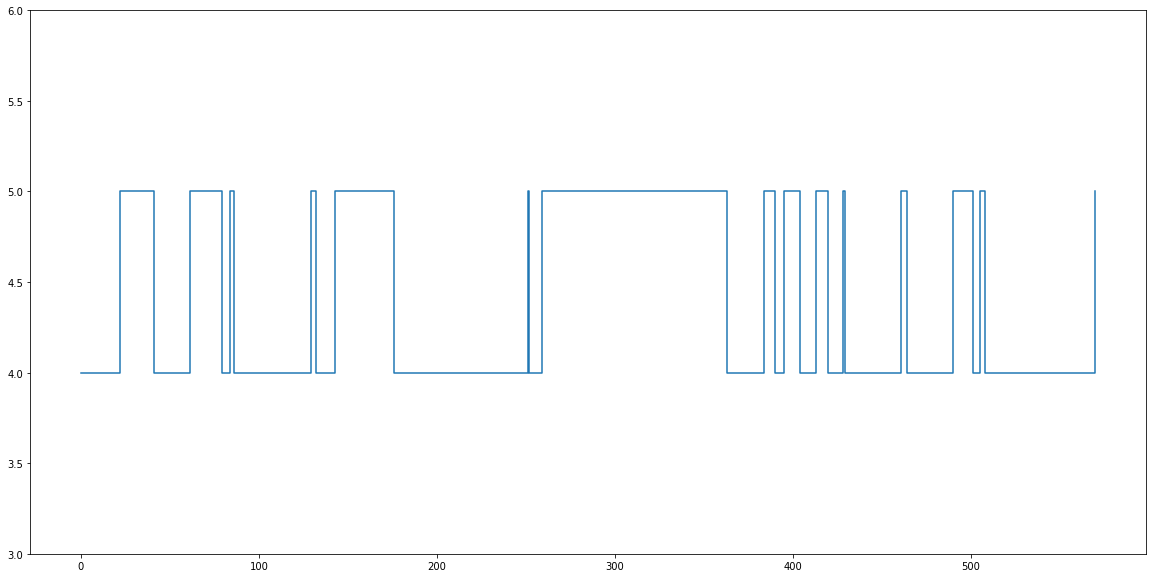

In [29]:
AddStatistics(DEVS.stats, "dynamic_general_queue")
PrintServerNumPlot()


### 4. Dynamic Shortest queue

In [30]:
# simulation attributes
DEVS.Clear()
AE = ArrivalEvent()
DEVS.EQ.AddEvent(AE)
DEVS.singleQueue = False
DEVS.dynamicQueues = True
DEVS.Servers = []

for idx in range(DEVS.NumServers):
    server = Server()
    DEVS.Servers.append(server)
    DEVS.customerQueues[idx] = []


DEVS.Servers[-1].Active = False # Set 5th server as inactive

# --- SIMULATION ---
while DEVS.EQ.QueueSize()>0:
    DEVS.ProcessNextEvent()  

Time 0  Arrival Event of agent 0
server[0] takes customer 0
Time 2  Arrival Event of agent 1
server[1] takes customer 1
Time 10  Arrival Event of agent 2
server[2] takes customer 2
Time 13 Service of customer 0 finished
server[0] is Idle (do nothing)
Time 15  Arrival Event of agent 3
server[0] takes customer 3
Time 19 Service of customer 1 finished
server[1] is Idle (do nothing)
Time 21  Arrival Event of agent 4
server[1] takes customer 4
Time 24  Arrival Event of agent 5
server[3] takes customer 5
Time 26 Service of customer 2 finished
server[2] is Idle (do nothing)
Time 31 Service of customer 3 finished
server[0] is Idle (do nothing)
Time 32  Arrival Event of agent 6
server[0] takes customer 6
Time 34 Service of customer 4 finished
server[1] is Idle (do nothing)
Time 38 Service of customer 5 finished
server[3] is Idle (do nothing)
Time 39  Arrival Event of agent 7
server[1] takes customer 7
Time 45  Arrival Event of agent 8
server[2] takes customer 8
Time 50 Service of customer 6 fin

[(0.0, 4), (96.0, 5), (106.0, 4), (108.0, 5), (123.0, 4), (156.0, 5), (166.0, 4), (188.0, 5), (193.0, 4), (205.0, 5), (220.0, 4), (356.0, 5), (368.0, 4), (530.0, 5), (531.0, 4), (706.0, 5), (707.0, 4), (719.0, 5), (740.0, 4), (754.0, 5), (771.0, 4), (843.0, 5), (849.0, 4), (895.0, 5), (902.0, 4), (913.0, 5), (922.0, 4), (931.0, 5), (953.0, 4), (1006.0, 5)]


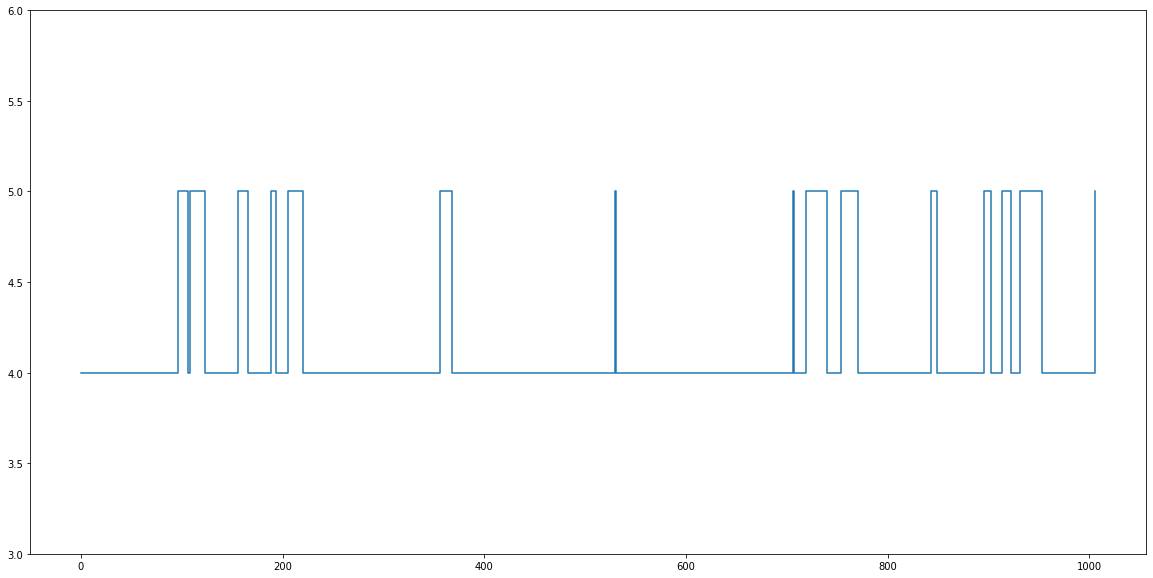

In [31]:
AddStatistics(DEVS.stats, "dynamic_shortest_queue")
PrintServerNumPlot()

### Statistics

In [32]:
PrintStatistics()

+------------------------+---------------------+-----------------------+----------------+---------------------------------+----------------------+
|         Model          | Prob of Idle server | Prob customer to wait | Avg  wait time | Avg time customer in the system |    Avg queue len     |
+------------------------+---------------------+-----------------------+----------------+---------------------------------+----------------------+
|     general_queue      | 0.12650640024976584 |          0.53         |     3.596      |              19.611             | 0.22453949422416483  |
|     shortest_queue     | 0.13110172649360327 |         0.476         |      5.26      |              21.362             | 0.32666749472115264  |
| dynamic_general_queue  |  0.3764319772122113 |         0.254         |     0.889      |              17.038             | 0.055049848287819676 |
| dynamic_shortest_queue | 0.42263868999439635 |         0.242         |     2.143      |              18.204         

## Conclusions

All four models were implemented, tested and compared.
As a result, the best average timing results are shown by "dynamic_general_queue" model.The worst results are gained from "shortest_queue" model. It is necessary to mention. that models with general queue have higher probability for customer to wait in queue, than shortest queue models. At the same time the amount of waiting time in queue for general queue models is significantly less than for shortest queue models.
This is because "general queue" models provide more uniform distribution of customers to servers, while for "shortest queue" models there is a possible situation where one server is idle and another one has a non empty queue.